## Purpose 
First simple model showed that using TF-IDF vectorizer and NMF decomposition led to the topics that made the most sense. 
Will re-iterate that pipeline only here, and expand analysis, for the us_pops data.
For anlysis, will do K-means clustering and NMF


In [1]:
import pickle
import numpy as np
import pandas as pd

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.feature_extraction import text

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

## 1. Reiteration of the cleaning, TF-IDF, and NMF from the first_simple_model

In [2]:
file = open('../../Webscraper/us_pops_raw', 'rb')
us_pops_raw = pickle.load(file)
us_pops_raw = us_pops_raw.dropna().reset_index(drop=True)
us_pops = us_pops_raw['Lyrics']

# only keep alphanumeric, remove newlines, and make everything lowercase
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
rm_newline = lambda x: re.sub("\n", ' ',x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

us_pops_nopunc = us_pops.map(alphanumeric).map(rm_newline).map(punc_lower)

In [3]:
# lemmatize. do this by turning every line into a list of words, and concat back to full lyrics
us_pops_list = us_pops_nopunc.apply(lambda x: x.split(' '))

def lemmatize(list_of_words):
    lmt = WordNetLemmatizer()
    strg = ''
    for word in list_of_words:
        lem_word = lmt.lemmatize(word)
        if len(lem_word) > 2:
            strg += lem_word + ' '
    return strg

us_pops_clean = us_pops_list.apply(lemmatize)

In [4]:
stop_words_added = text.ENGLISH_STOP_WORDS.union(['huh','woo','whoa','hey','hold','really','gotta'])

tfidf =  TfidfVectorizer(
    stop_words = stop_words_added,
    max_df = 0.2,
    min_df = 0.0005
)
Y = tfidf.fit_transform(us_pops_clean)
doc_term_matrix = pd.DataFrame(Y.toarray(), columns=tfidf.get_feature_names())

In [5]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [6]:
nmf_model = NMF(5, random_state = 42)
doc_topic = nmf_model.fit_transform(doc_term_matrix)

display_topics(nmf_model, tfidf.get_feature_names(), 25)


Topic  0
believe, dream, stay, friend, gone, try, forever, better, true, long, home, wrong, fall, lie, inside, leave, wish, change, thought, face, place, going, did, feeling, miss

Topic  1
nigga, bitch, shit, fuck, ayy, money, gon, real, bad, lil, hoe, big, hit, fuckin, pussy, dick, bout, drop, pop, young, damn, hot, gettin, rich, new

Topic  2
tonight, alright, waiting, tomorrow, fight, party, kiss, drink, tight, inside, dancing, touch, boo, end, leave, broken, body, holding, lovin, light, looking, jump, turn, ready, dark

Topic  3
dance, body, shake, rock, everybody, party, stop, turn, floor, play, music, round, roll, club, beat, lady, song, hot, touch, work, slow, wit, gon, hit, groove

Topic  4
remember, used, memory, forget, gave, bring, fell, saying, wish, hurt, walk, bye, picture, sad, century, yesterday, loving, lonely, alright, couldn, walking, bee, danced, walked, cried


## 2. Exploration of the resulting dataframe from NMF

In [7]:
#rename the topics to words I see fit
doc_topic_mat = pd.DataFrame(
    doc_topic.round(3),
    columns = ['"Dreams"','"Expletives"','"Passion"','"Dance"','"Reminiscence"']
)

# re-add Song/Artist
doc_topic_mat = doc_topic_mat.join(us_pops_raw[['Song','Artist']])

In [8]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna
...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.080,Eyes on You,Chase Rice
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink


In [9]:
doc_topic_mat.sort_values('"Reminiscence"',ascending=False).head()

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist
49,0.000,0.0,0.0,0.0,0.588,Do You Remember,Phil Collins
212,0.000,0.0,0.0,0.0,0.581,Remember the Time,Michael Jackson
1617,0.003,0.0,0.0,0.0,0.553,Walk Away (Remember Me),Paula DeAnda featuring The D.E.Y.
398,0.000,0.0,0.0,0.0,0.534,I'll Remember,Madonna
551,0.000,0.0,0.0,0.0,0.527,You Used to Love Me,Faith Evans


## 3. K-means clustering and PCA

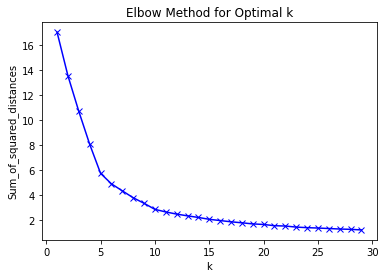

In [10]:
# Attemp to see an 'elbow' to optimize the K-value for K-means clustering

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(doc_topic_mat.iloc[:,:5])
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()

#### Try k=5, 10, or 15 as elbow

In [11]:
# PCA

# Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Load in the data
df = doc_topic_mat.iloc[:,:5]

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)

# Create a PCA instance: pca
pca = PCA(n_components=2)
pca.fit_transform(X_std)

x_pca = pca.transform(X_std)

In [12]:
modelkmeans = KMeans(n_clusters = 15, random_state = 42)
# hello = modelkmeans.fit(doc_topic_mat.iloc[:,:5])
labels = modelkmeans.fit_predict(doc_topic_mat.iloc[:,:5])

doc_topic_mat['cluster'] = labels

In [13]:
doc_topic_mat

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence""",Song,Artist,cluster
0,0.061,0.000,0.000,0.011,0.000,Hold On,Wilson Phillips,0
1,0.063,0.000,0.006,0.007,0.000,It Must Have Been Love,Roxette,0
2,0.041,0.002,0.000,0.000,0.010,Nothing Compares 2 U,Sinéad O'Connor,14
3,0.019,0.011,0.002,0.017,0.001,Poison,Bell Biv DeVoe,5
4,0.000,0.000,0.000,0.080,0.001,Vogue,Madonna,9
...,...,...,...,...,...,...,...,...
2666,0.052,0.000,0.000,0.001,0.080,Eyes on You,Chase Rice,1
2667,0.039,0.000,0.006,0.056,0.000,All to Myself,Dan + Shay,8
2668,0.022,0.006,0.003,0.011,0.000,Boyfriend,Ariana Grande and Social House,5
2669,0.056,0.004,0.132,0.000,0.000,Walk Me Home,Pink,2


In [14]:
# Look at mean topic scores for all 15 clusters

doc_topic_mat.groupby(['cluster']).mean()*100

,"""Dreams""","""Expletives""","""Passion""","""Dance""","""Reminiscence"""
cluster,,,,,
0,7.030976,0.455854,0.260244,0.554146,0.429268
1,4.305970,0.613433,0.319403,0.962687,6.205970
2,3.609412,0.741176,8.958824,1.534118,0.487059
3,0.376923,0.046154,0.476923,0.192308,46.907692
4,1.186364,12.594545,0.254545,2.249091,0.153636
5,1.666385,0.821987,0.289852,1.232981,0.221987
6,0.260526,0.726316,0.631579,20.910526,0.244737
7,0.654545,0.890909,36.272727,2.045455,0.645455
8,2.332840,1.304734,0.498225,5.080769,0.267160


In [15]:
# count of songs within each cluster
doc_topic_mat.groupby(['cluster']).count().iloc[:,0]

cluster
0     410
1      67
2      85
3      13
4     110
5     473
6      38
7      11
8     338
9     125
10    191
11     54
12     19
13     31
14    706
Name: "Dreams", dtype: int64

In [16]:
# First, only select songs from the 90s and songs in the 2010s
# Second, look at which cluster changed their count the most
# The song counts of 1990s and 2010s are almost identical, so can do pure counts rather than % of songs in that decade

nineties = doc_topic_mat.iloc[:866].groupby(['cluster']).count().iloc[:,0]
tens = doc_topic_mat.iloc[1812:].groupby(['cluster']).count().iloc[:,0]
tens/nineties

cluster
0     0.435028
1     0.818182
2     1.250000
3     0.285714
4     3.666667
5     1.231788
6     0.900000
7     1.666667
8     0.935185
9     1.290323
10    2.371429
11    6.000000
12    2.500000
13    1.444444
14    0.734848
Name: "Dreams", dtype: float64

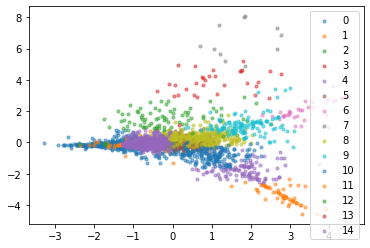

In [17]:
# Plot clusters with PCA

fig, ax = plt.subplots()
for g in np.unique(labels):
    ix = np.where(labels == g)
    ax.scatter(x_pca[:,0][ix], x_pca[:,1][ix], label = g, s = 10 ,alpha = 0.5)
ax.legend()
plt.show()

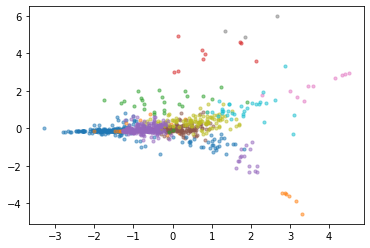

In [18]:
#Same plot as above, but only with the songs in the 90s
labels_90 = labels[:866] 
x_pca_90 = x_pca[:866]

fig, ax = plt.subplots()
for g in np.unique(labels_90):
    ix = np.where(labels_90 == g)
    ax.scatter(x_pca_90[:,0][ix], x_pca_90[:,1][ix], label = g, s = 10 ,alpha = 0.5)
# ax.legend()
plt.show()

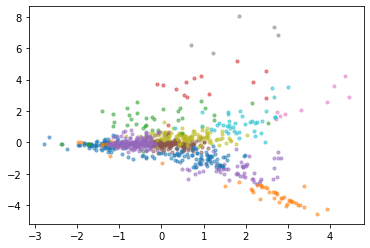

In [19]:
#Same plot as above, but only with the songs in the 2010s
labels_10 = labels[1812:] 
x_pca_10 = x_pca[1812:]

fig, ax = plt.subplots()
for g in np.unique(labels_10):
    ix = np.where(labels_10 == g)
    ax.scatter(x_pca_10[:,0][ix], x_pca_10[:,1][ix], label = g, s = 10 ,alpha = 0.5)
# ax.legend()
plt.show()